In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob
import json
import os

from IPython.display import display, HTML

In [2]:
sns.set_context("poster")
sns.set_style("ticks")

In [3]:
def get_all_epoch_data(model_path):
    epoch_metrics_files = [os.path.normpath(path) for path in glob(f"{model_path}/metrics_epoch_*.json")]
    epoch_data = []
    for file in epoch_metrics_files:
        with open(file) as fp:
            epoch_data.append(json.load(fp))
    return epoch_data

In [4]:
def parse_model_name(model_path):
    model = model_path.split(os.sep)[-1]
    model = model.replace("l2_0_lr_0.001", "*")
    model = model.replace("l2_0_lr_1e-3", "*")
    model = model.replace("no_neel_no_dimsum", "#") 
    model = model.replace("no_neel", "#") 
    model = model.replace("no_dimsum", "#")
    model = model.replace("self_attention", "sa")
    model = model.split("_")
    if model[0] != "all":
        model = [f"S_{model[0]}"] + model[2:]
    elif model[1] == "multitask":
        if model[2] == "stacked":
            model = ["MTL"]+model[3:]
        elif model[2] == "shared":
            model = ["MTS"]+model[3:]
    elif model[1] in {"ner", "pos"}:
        model = [f"MD_{model[1]}"]+model[2:]
    if len({"bilstm", "ssa"} & set(model)) == 0:
        model = model[:1] + ["bilstm"] + model[1:]
    # We cannot have different encoder for MTL stacked case, because of AllenNLP. It will be always biLSTM
    if model[1] == "ssa" and model[0] == "MTL":
        model[1] = "bilstm"
    model = " ".join(model)
    return model

In [5]:
def plot_epoch_metrics(df, col_wrap=5, **facet_kwargs):
    df_t = []
    for task, measure in [
            ("pos", "accuracy"),
            ("chunk", "f1-measure-overall"),
            ("ccg", "f1-measure-overall"),
            ("ner", "f1-measure-overall")
        ]:
        df_tt = df.filter(regex=f"{task}_{measure}$", axis=1).reset_index().melt(
            id_vars=["epoch"],
            value_name="score",
        )
        try:
            df_tt = df_tt.assign(
                eval_phase=lambda x: x["variable"].str.split("_", expand=True)[0],
                data=lambda x: x["variable"].str.split("_").map(lambda k: "_".join(k[1:3]))
            ).drop("variable", axis=1)
        except KeyError:
            continue
        df_t.append(df_tt)
    df_t = pd.concat(df_t)
    col_wrap = min(col_wrap, df_t.data.value_counts().shape[0])
    g = sns.FacetGrid(
        data=df_t,
        col="data",
        col_wrap=col_wrap,
        hue="eval_phase",
        sharey=False,
        height=4,
        palette=["k", "r"],
        **facet_kwargs
    )
    g = (g.map(plt.plot, "epoch", "score")).add_legend()
    return g

In [6]:
def plot_model(model_path):
    all_epoch_data = get_all_epoch_data(model_path)
    figure_title = f"{parse_model_name(model_path)}"
    measure_columns = [k for k in all_epoch_data[0].keys() if k.endswith(("accuracy", "overall")) and k.startswith(("training", "validation"))]
    columns = ["epoch", "training_loss", "validation_loss"] + measure_columns
    df = pd.DataFrame([
        [
            epoch_data[k]
            for k in columns
        ]
        for epoch_data in all_epoch_data
    ], columns=columns).sort_values("epoch").set_index("epoch")
    df.plot(y=["training_loss", "validation_loss"], color=["k", "r"])
    sns.despine(offset=10)
    plt.gcf().suptitle(figure_title)
    plt.show()
    plot_epoch_metrics(df, col_wrap=5)
    sns.despine(offset=10)
    plt.gcf().suptitle(figure_title, fontsize=16)
    plt.show()

In [7]:
model_paths = [os.path.normpath(path) for path in glob("../data/models/*")]
model_paths

['..\\data\\models\\all_multitask_shared',
 '..\\data\\models\\all_multitask_shared_l2_0_lr_1e-3',
 '..\\data\\models\\all_multitask_shared_l2_0_lr_1e-3_no_neel',
 '..\\data\\models\\all_multitask_shared_ssa_l2_0_lr_1e-3',
 '..\\data\\models\\all_multitask_shared_ssa_l2_0_lr_1e-3_no_neel',
 '..\\data\\models\\all_multitask_stacked',
 '..\\data\\models\\all_multitask_stacked_l2_0_lr_1e-3',
 '..\\data\\models\\all_multitask_stacked_l2_0_lr_1e-3_no_neel',
 '..\\data\\models\\all_multitask_stacked_ssa_l2_0_lr_1e-3',
 '..\\data\\models\\all_multitask_stacked_ssa_l2_0_lr_1e-3_no_neel',
 '..\\data\\models\\all_ner_bilstm',
 '..\\data\\models\\all_ner_bilstm_l2_0_lr_1e-3',
 '..\\data\\models\\all_ner_bilstm_l2_0_lr_1e-3_no_neel',
 '..\\data\\models\\all_ner_ssa_l2_0_lr_1e-3',
 '..\\data\\models\\all_ner_ssa_l2_0_lr_1e-3_no_neel',
 '..\\data\\models\\all_pos_bilstm',
 '..\\data\\models\\all_pos_bilstm_l2_0_lr_1e-3',
 '..\\data\\models\\all_pos_ssa_l2_0_lr_1e-3',
 '..\\data\\models\\ark_pos_bils

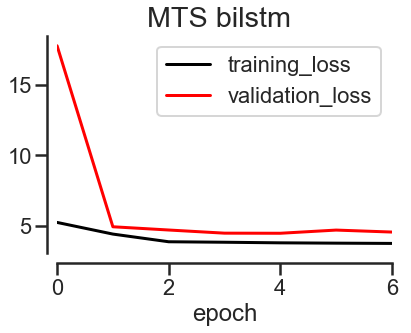

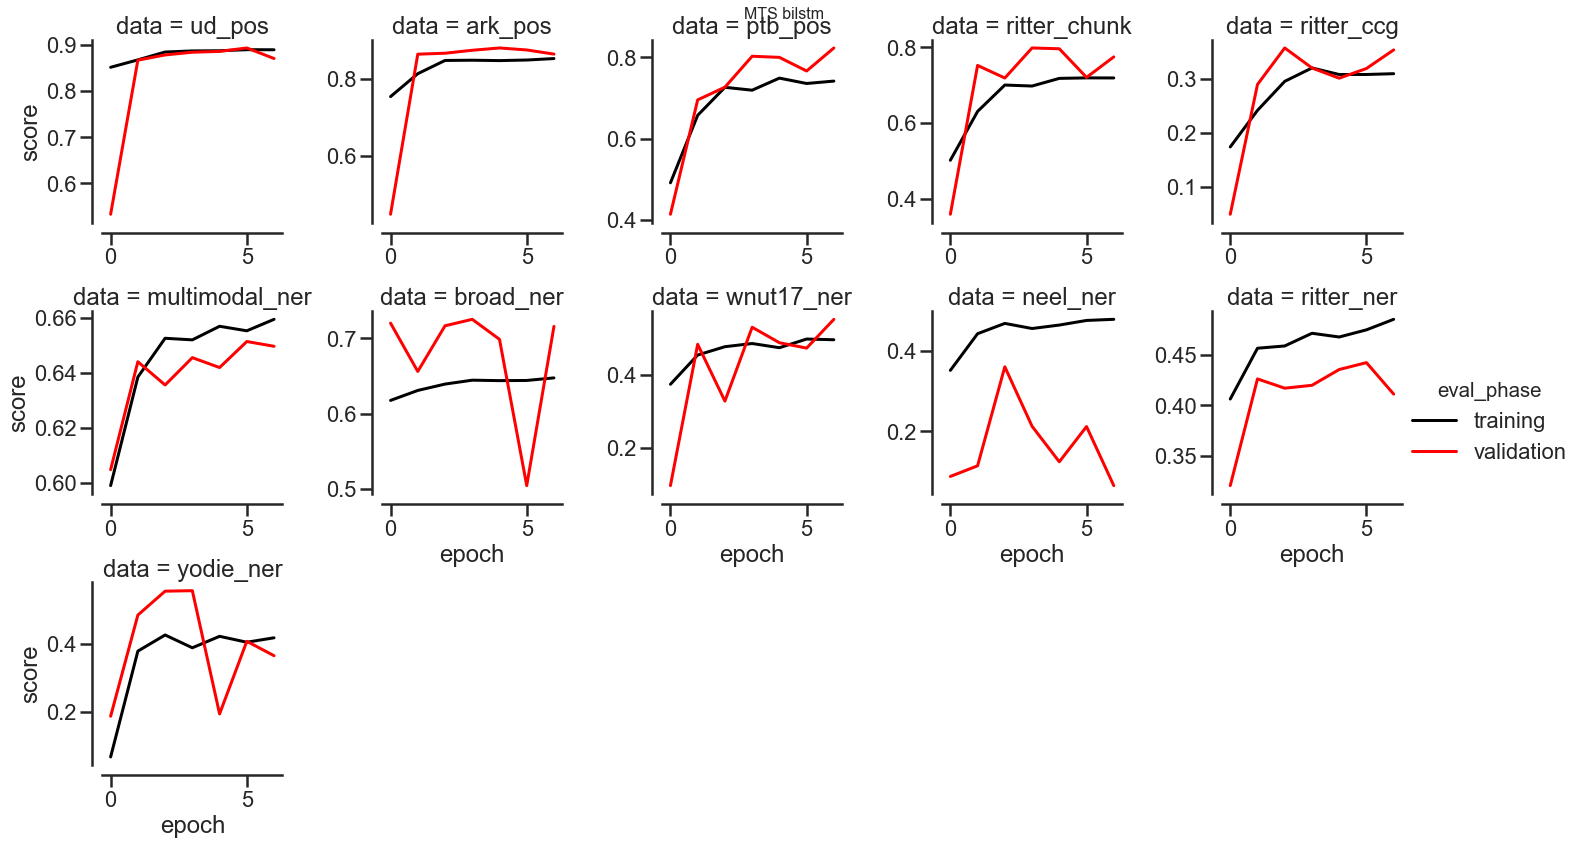

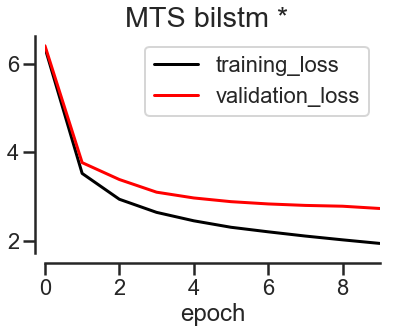

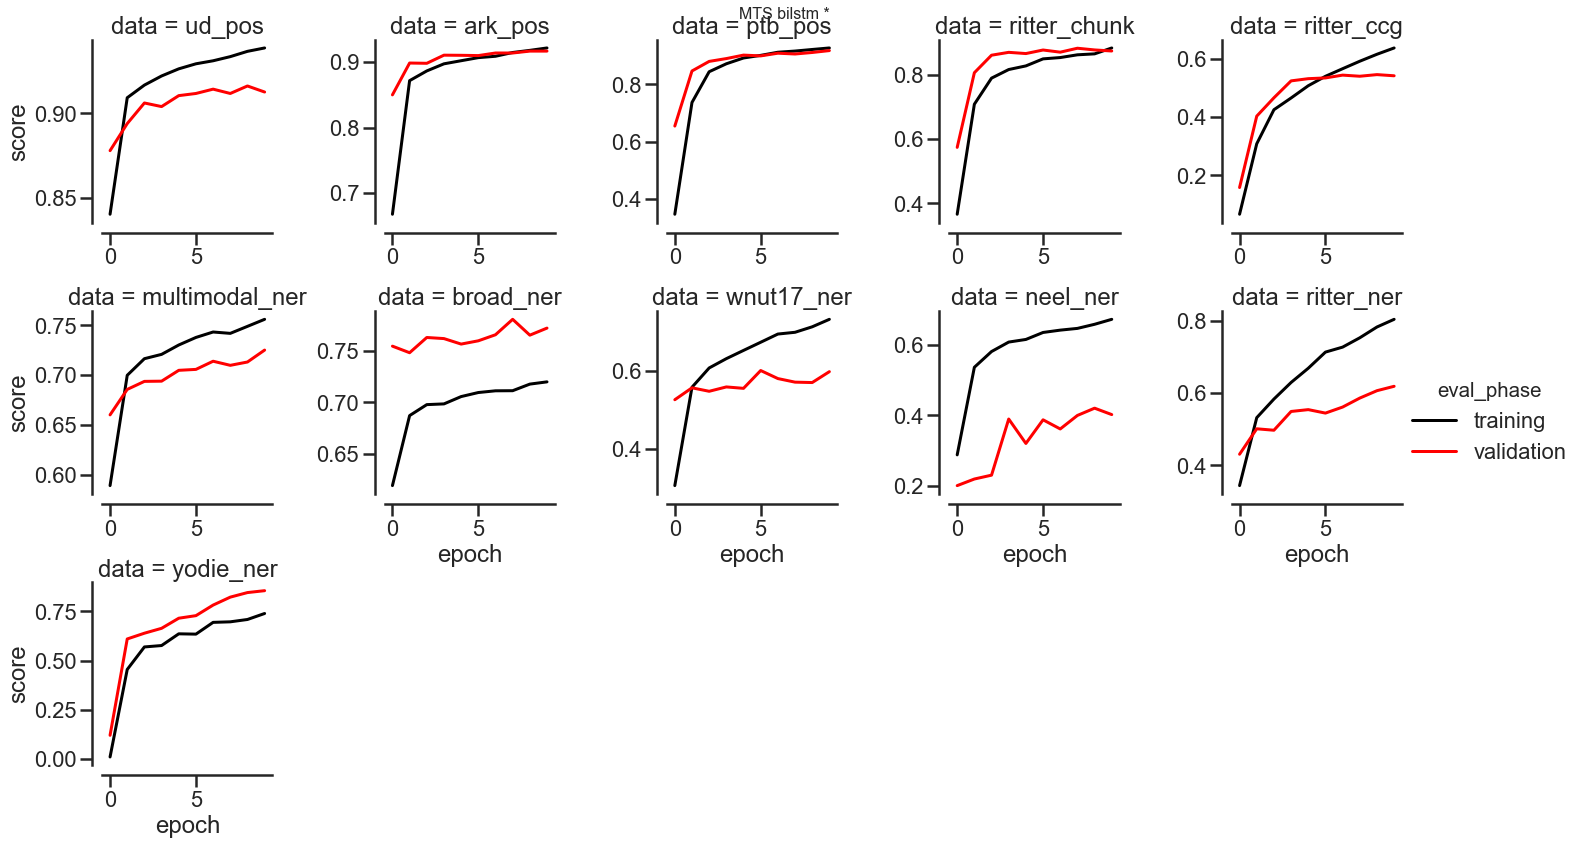

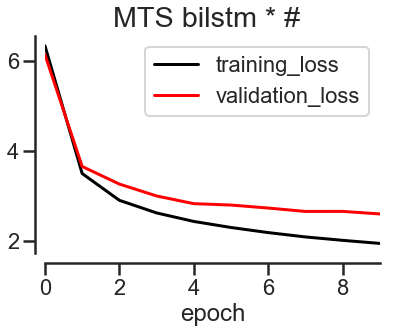

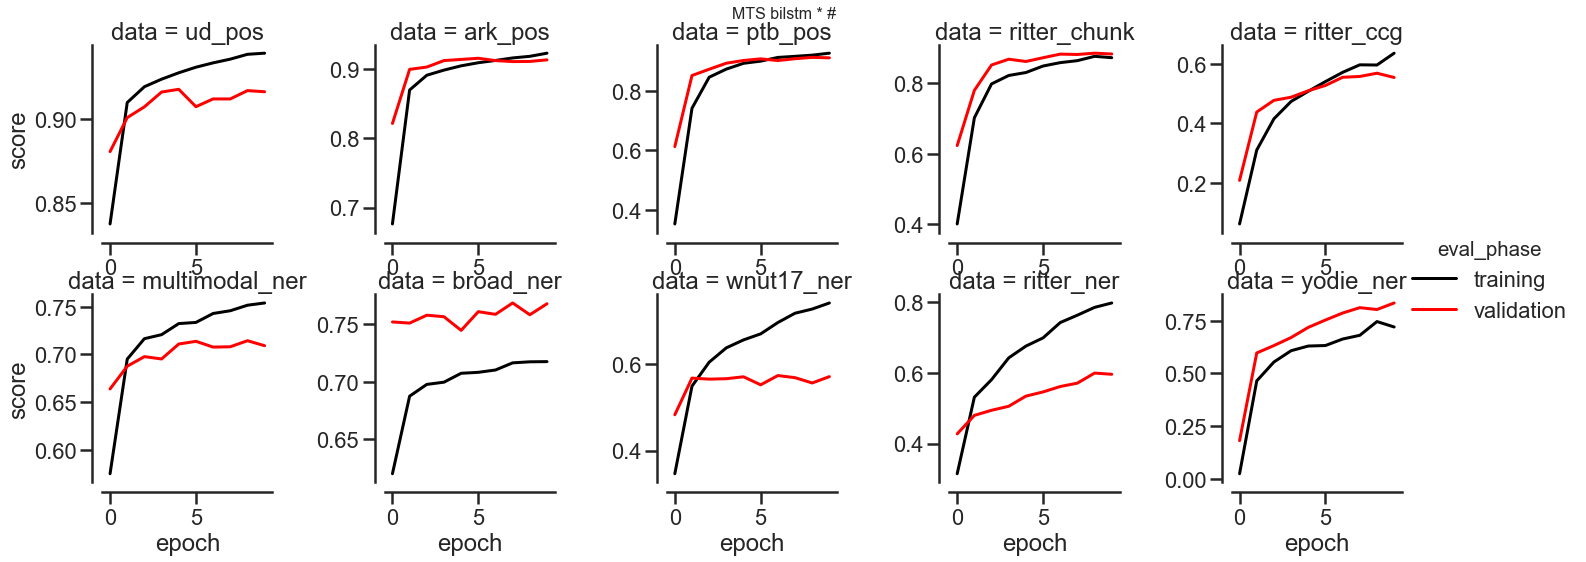

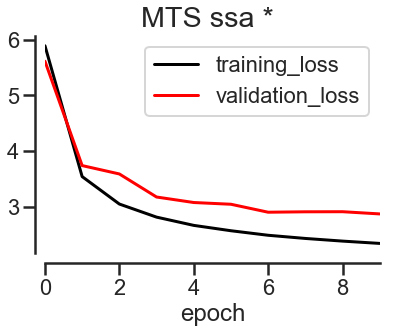

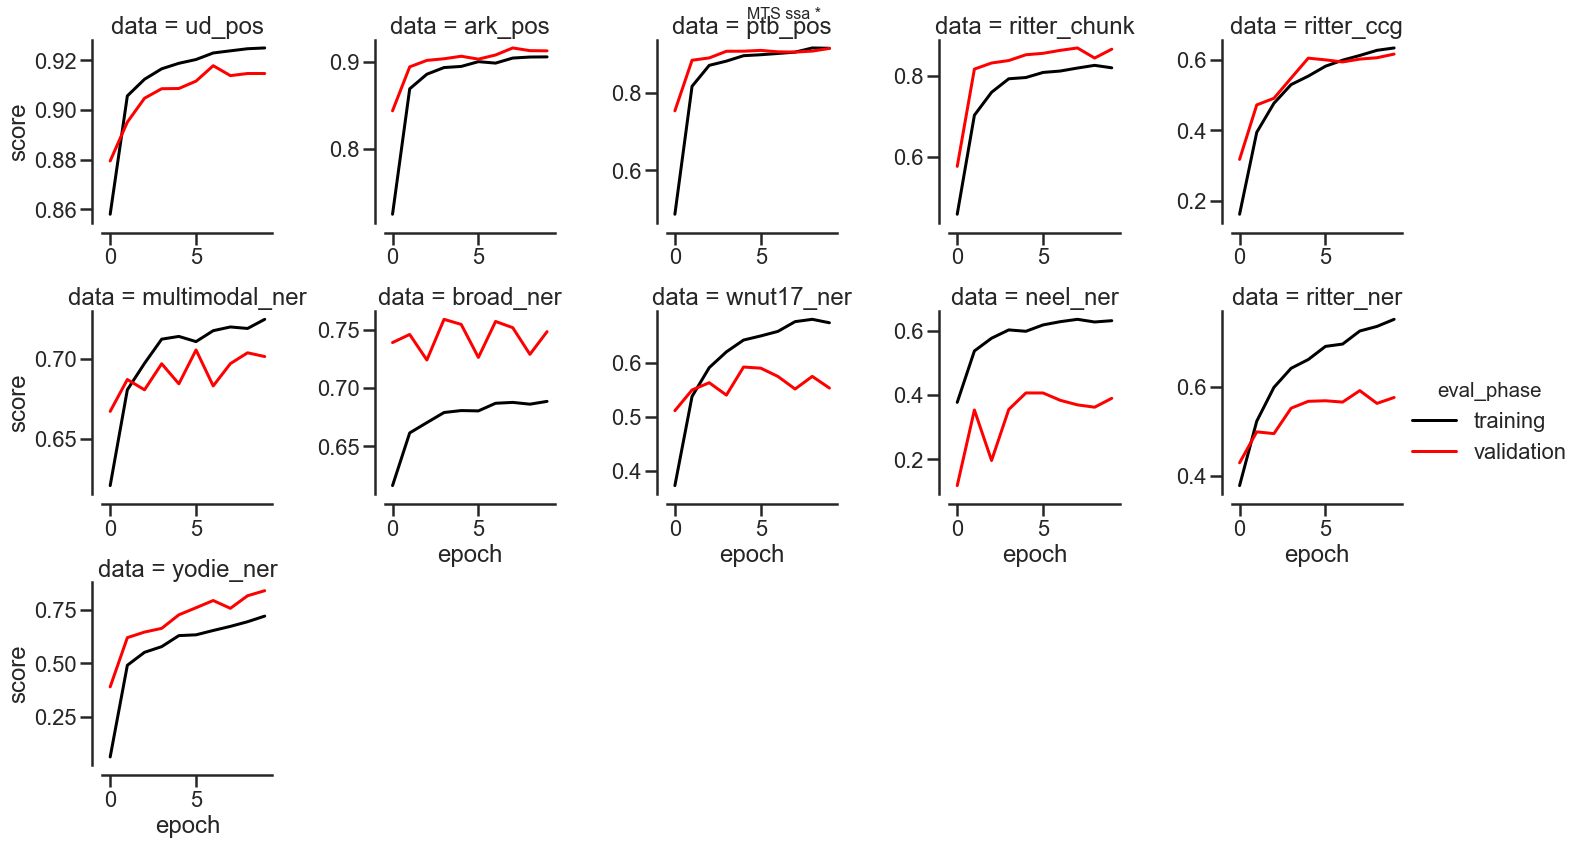

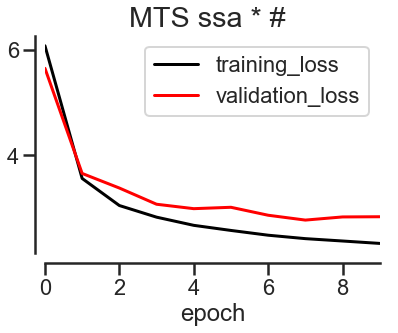

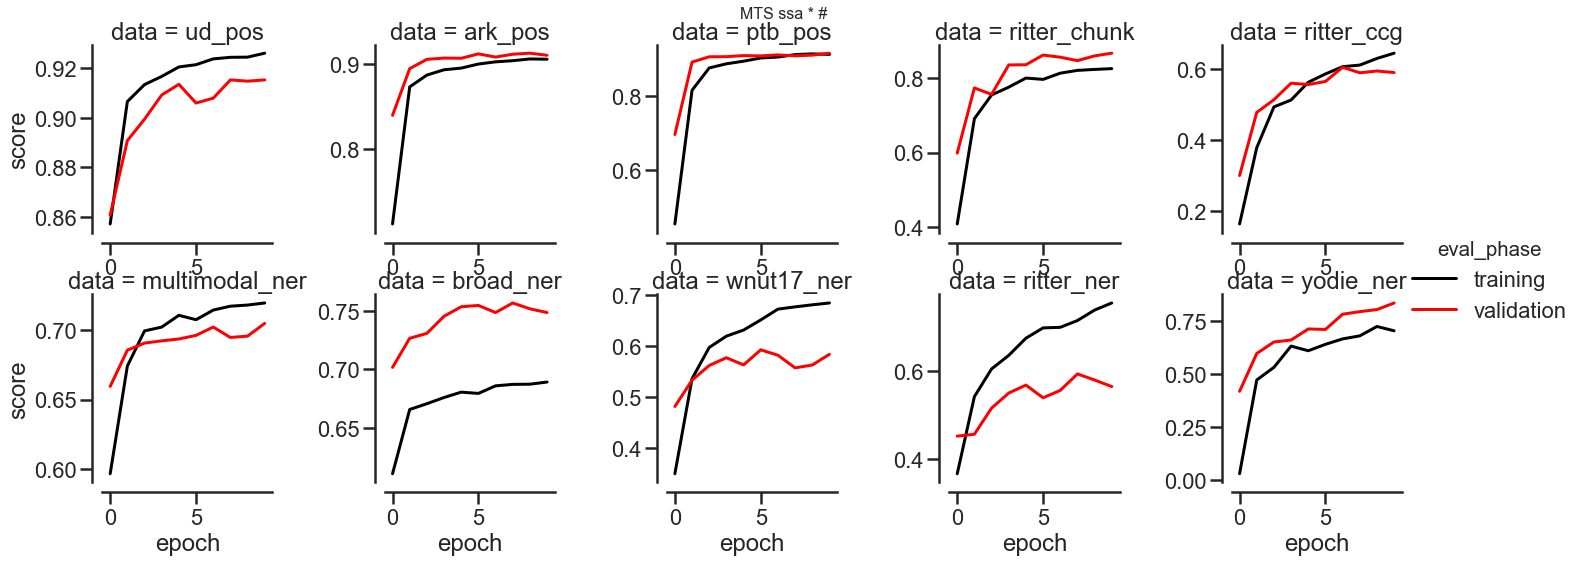

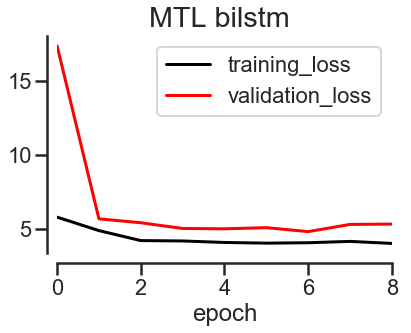

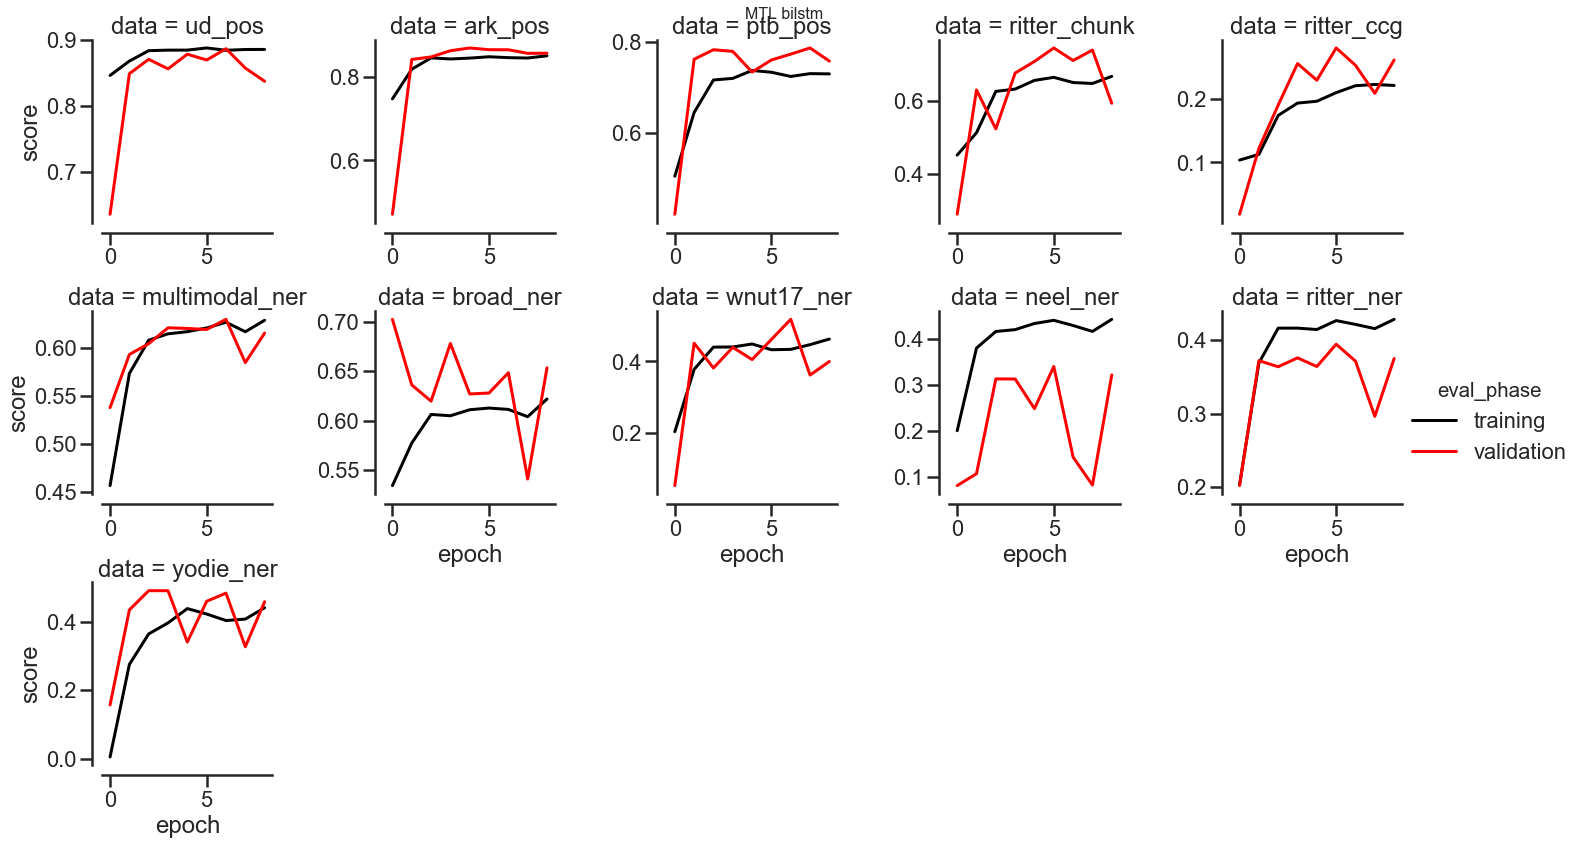

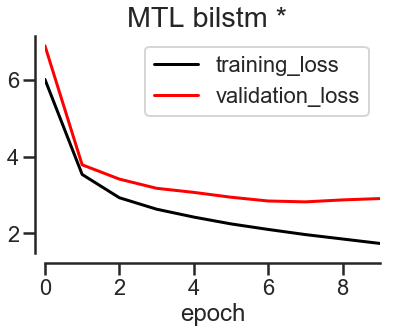

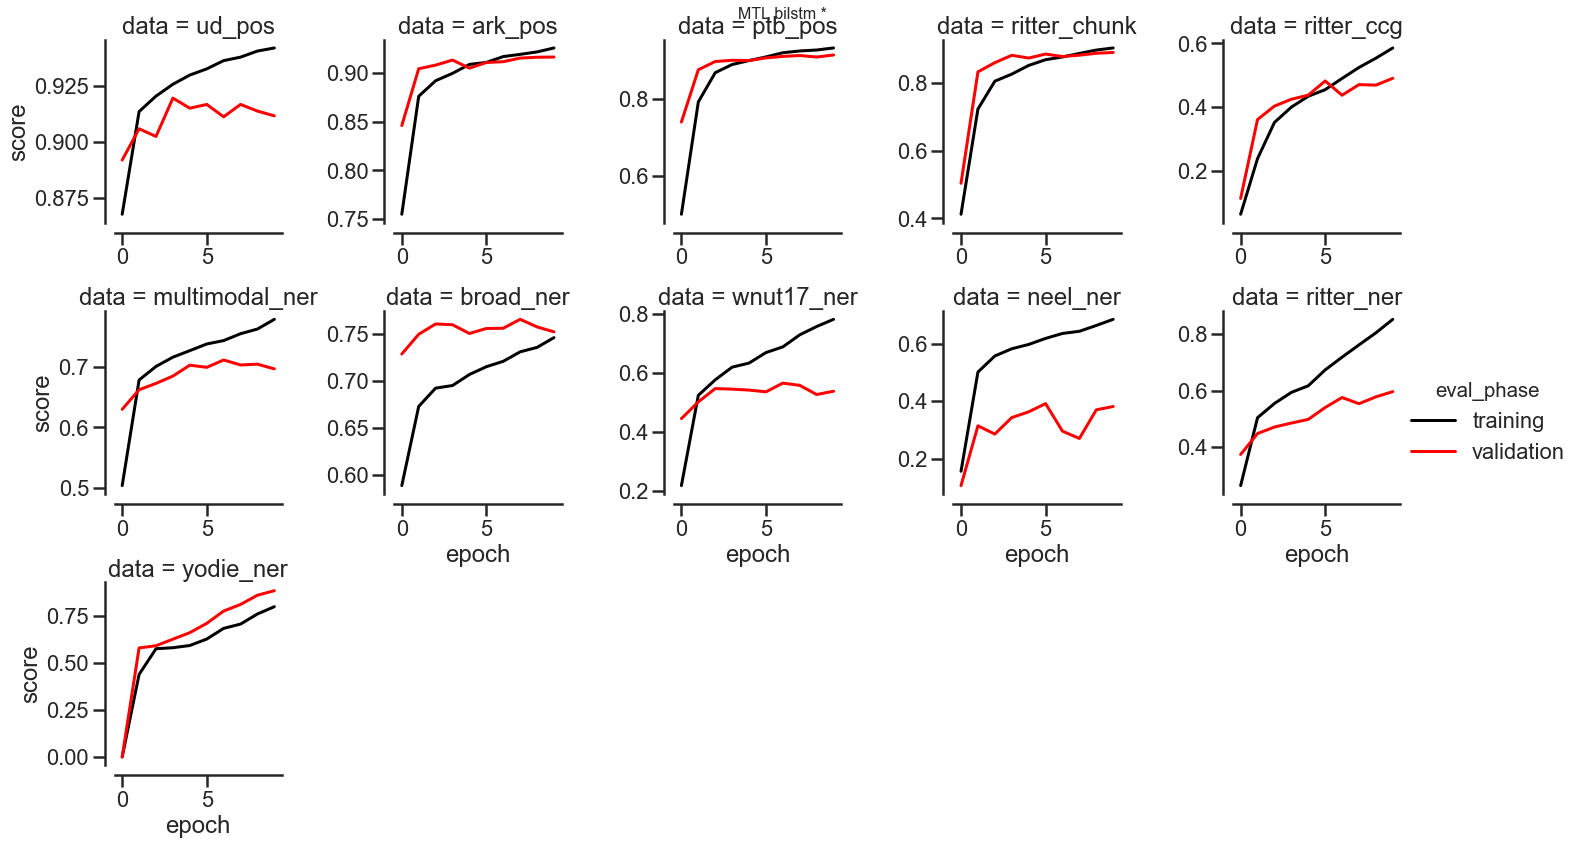

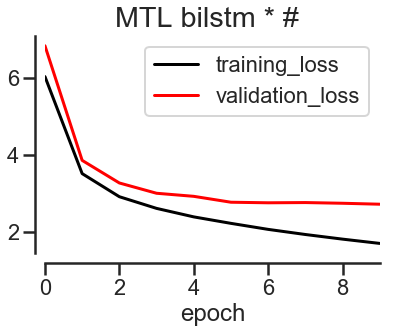

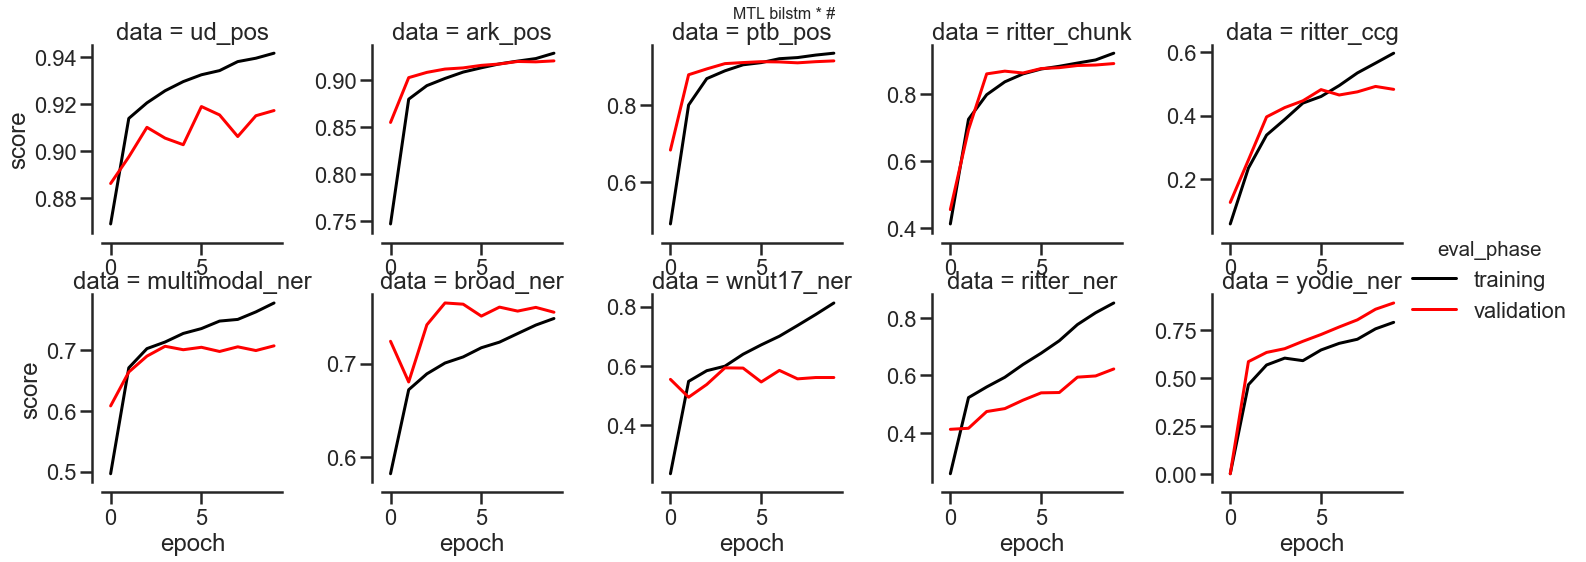

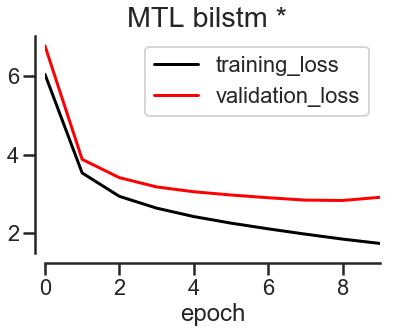

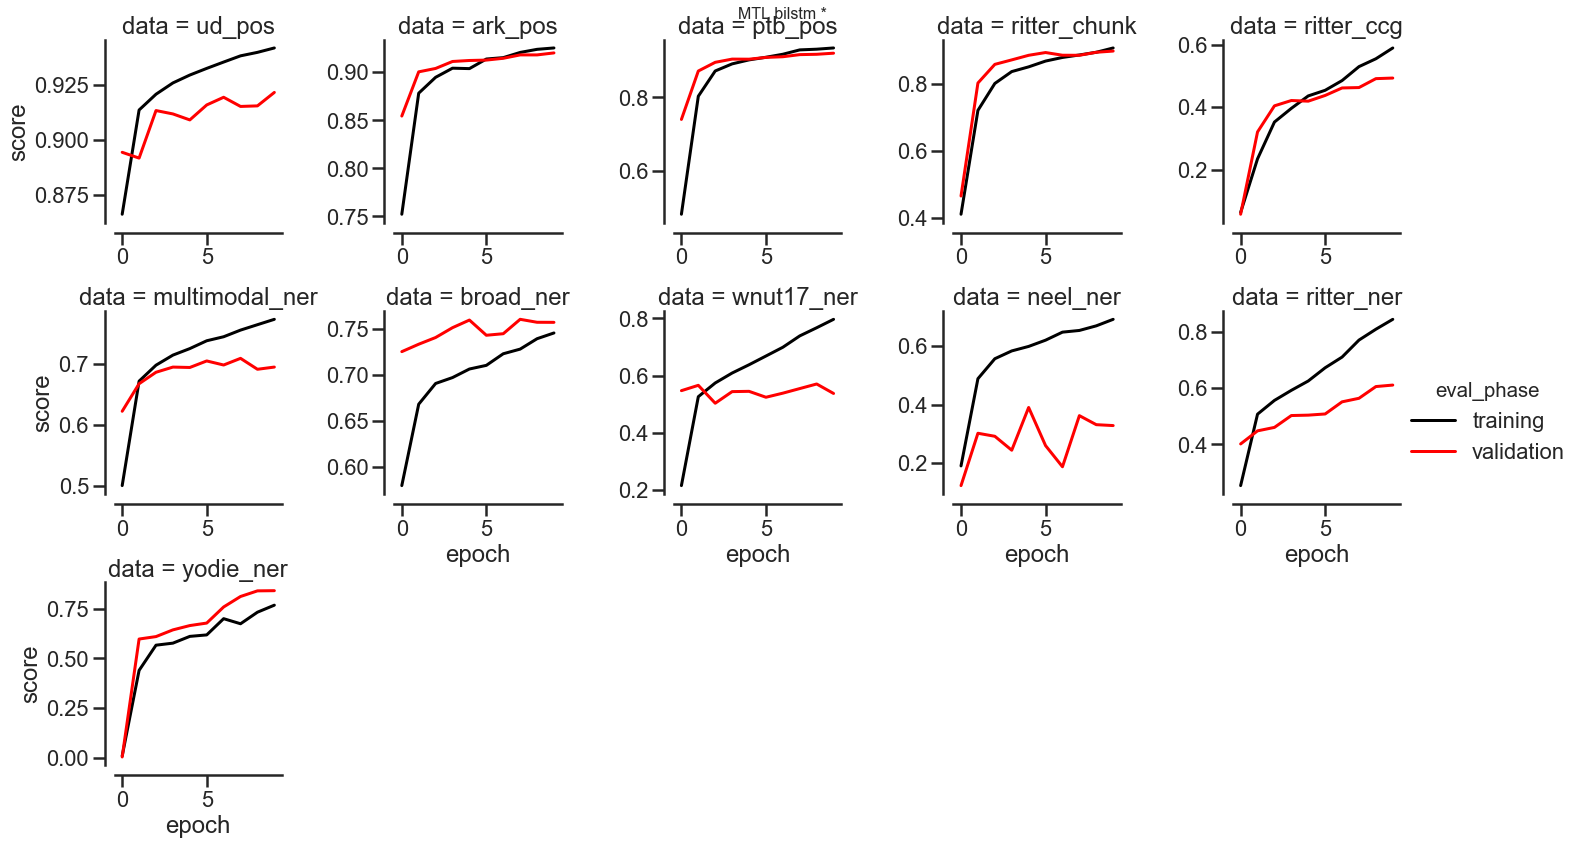

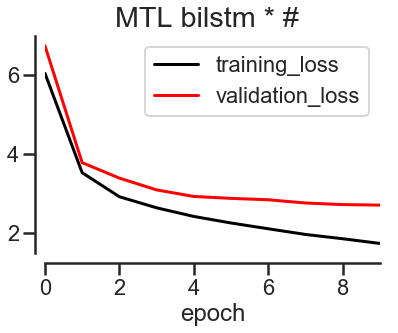

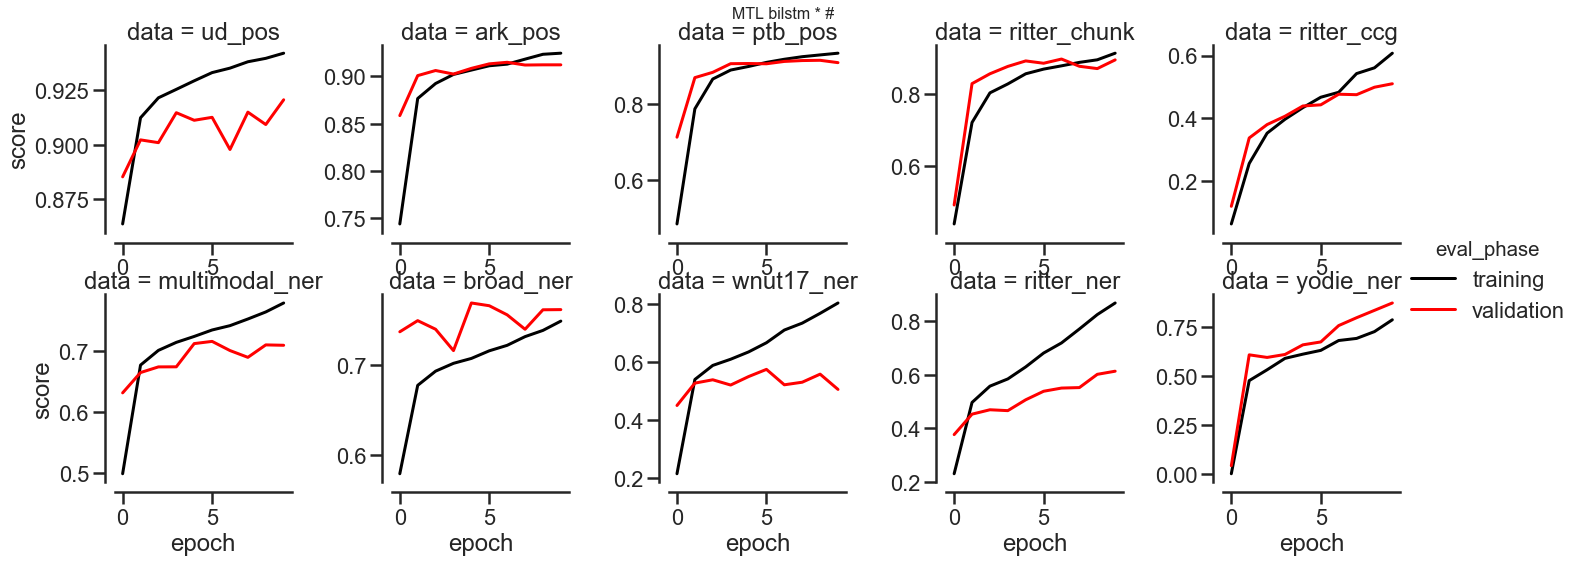

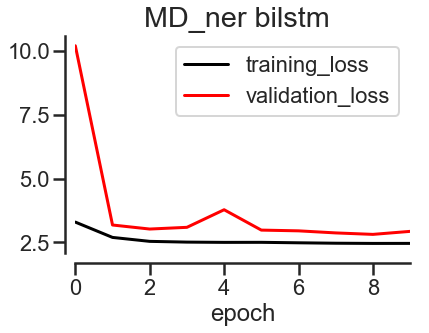

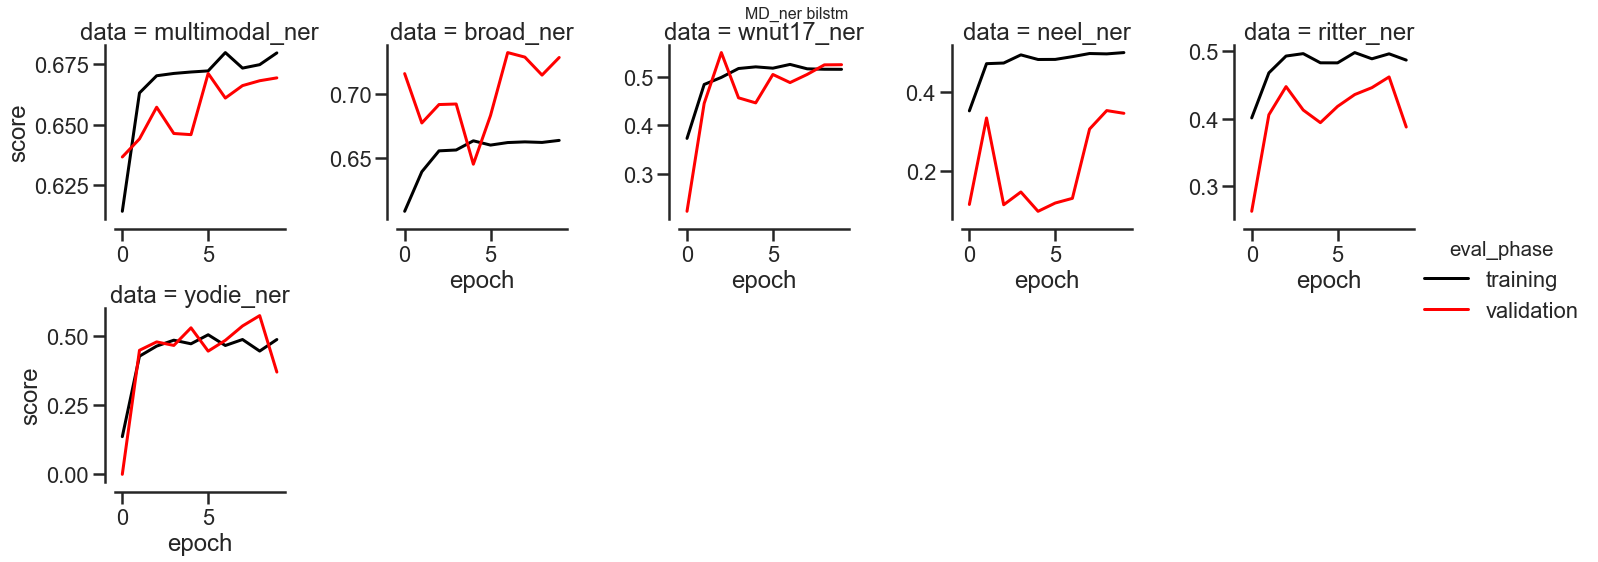

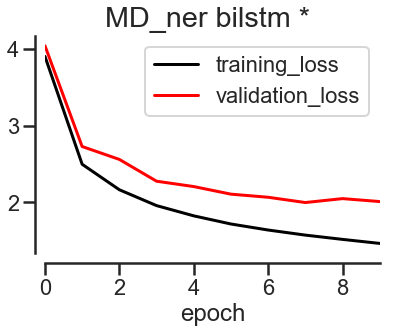

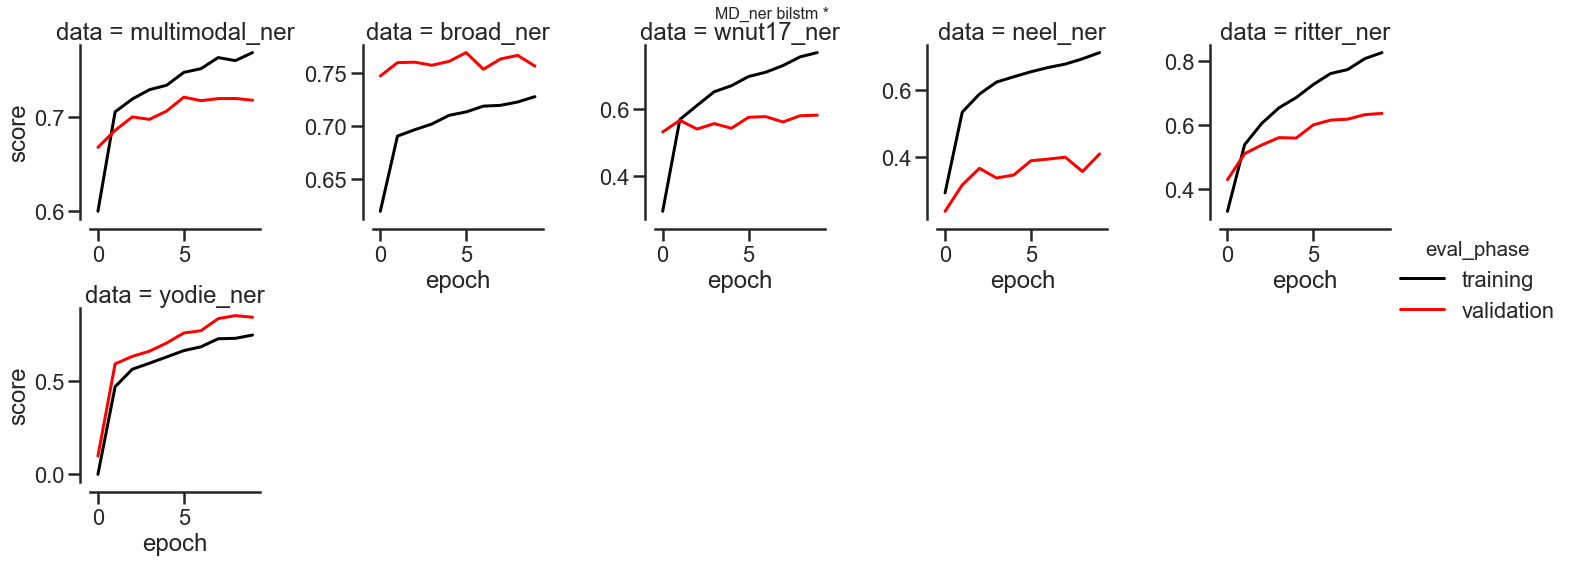

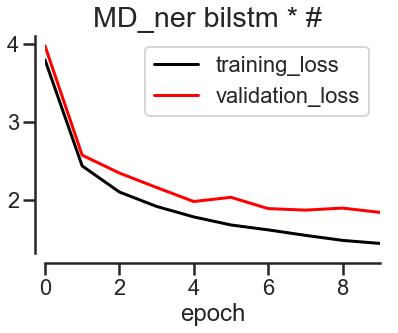

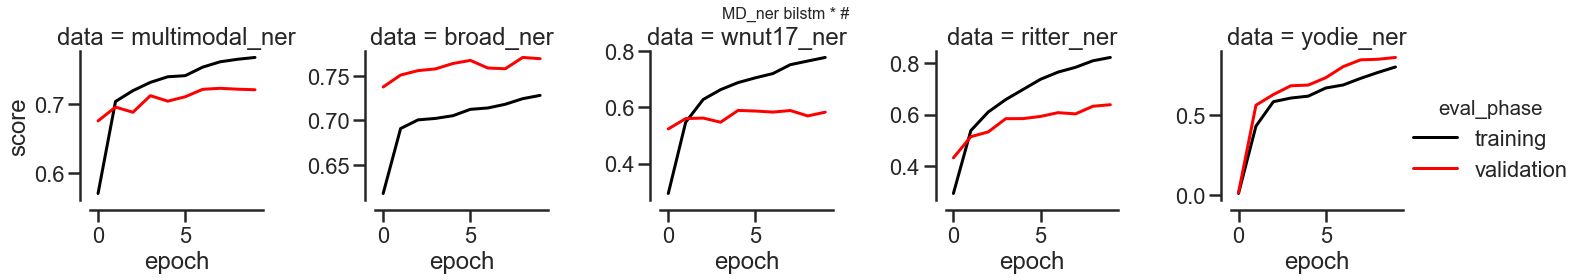

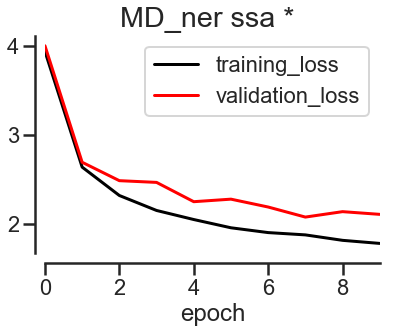

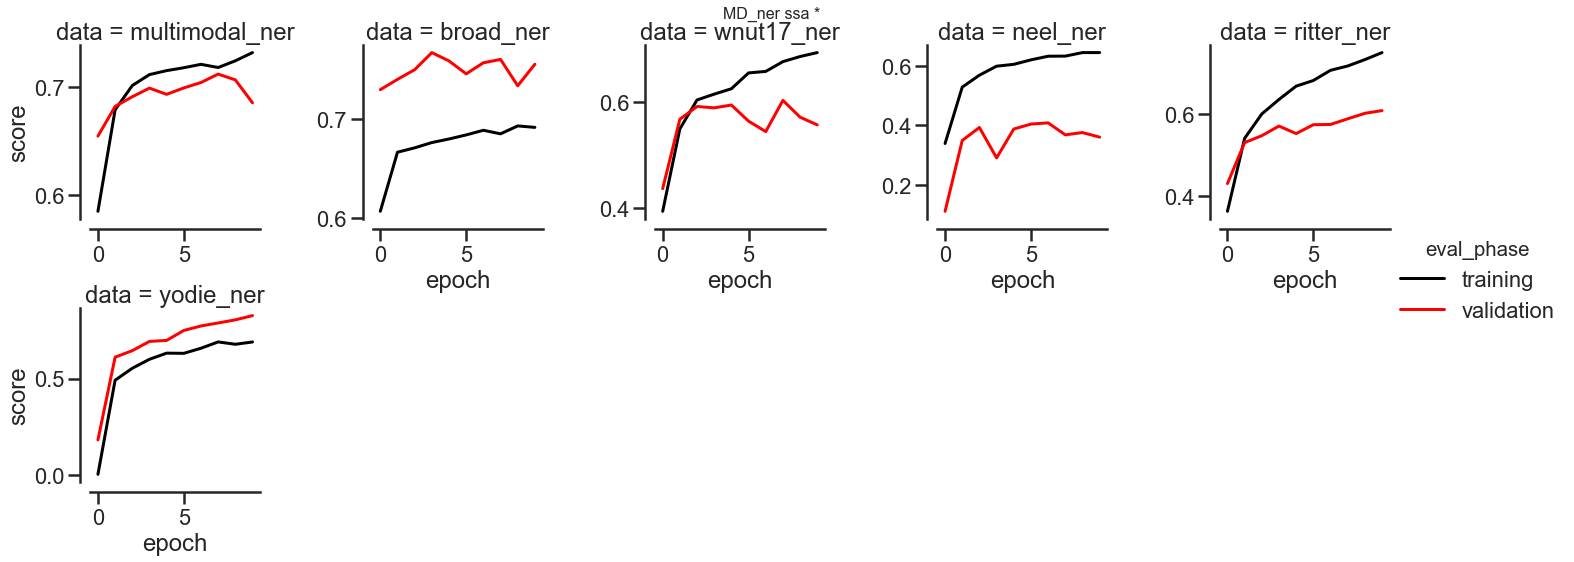

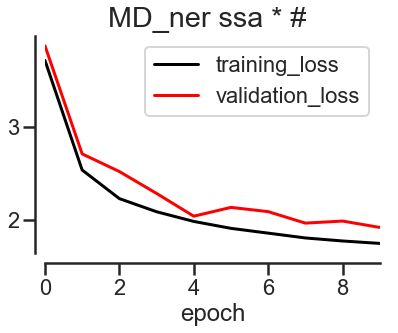

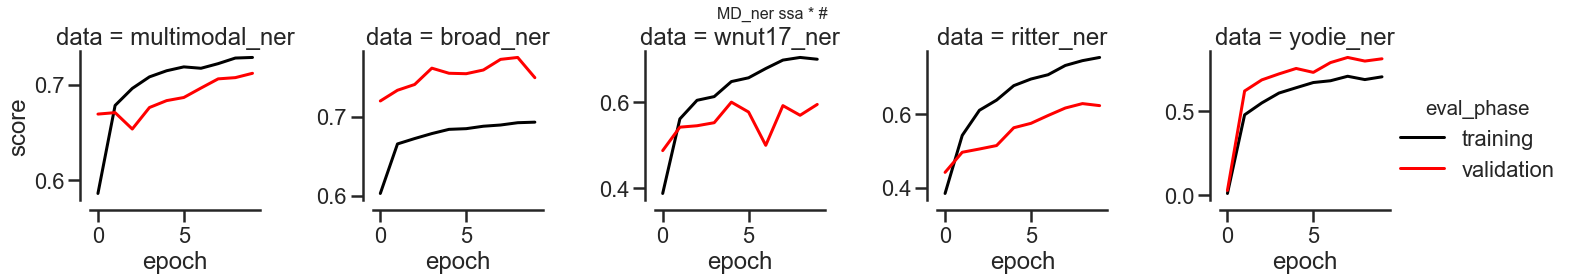

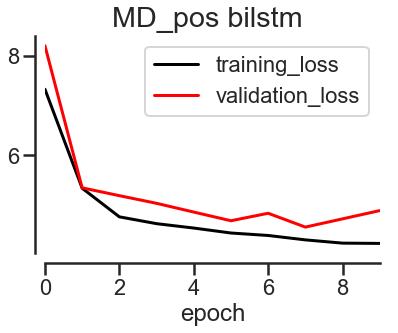

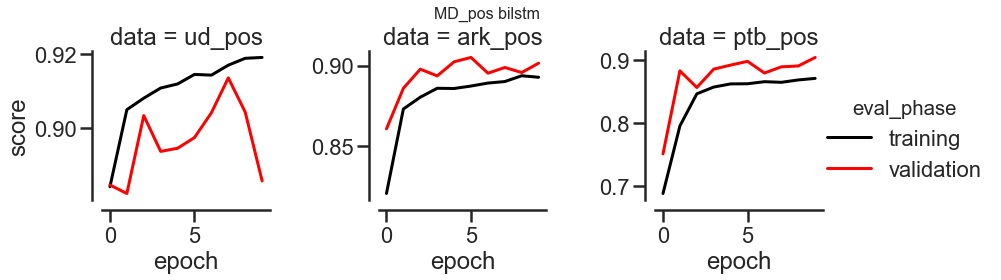

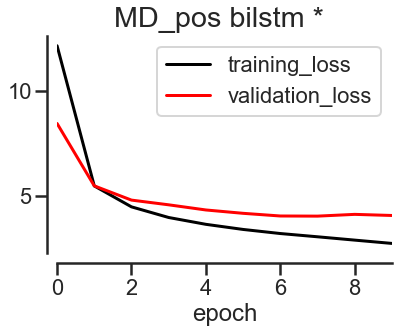

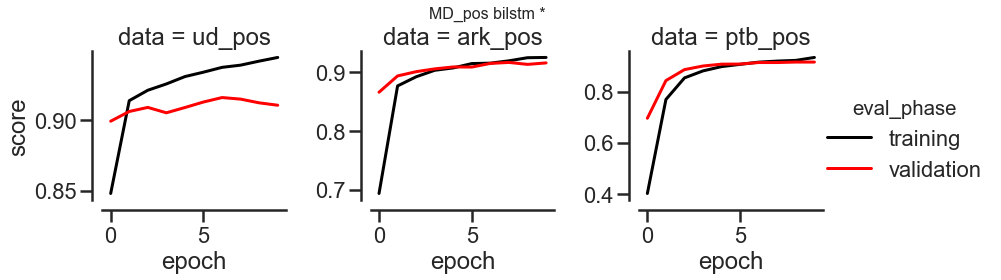

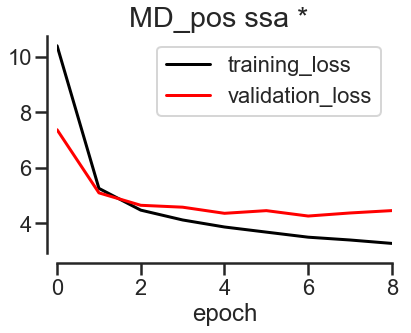

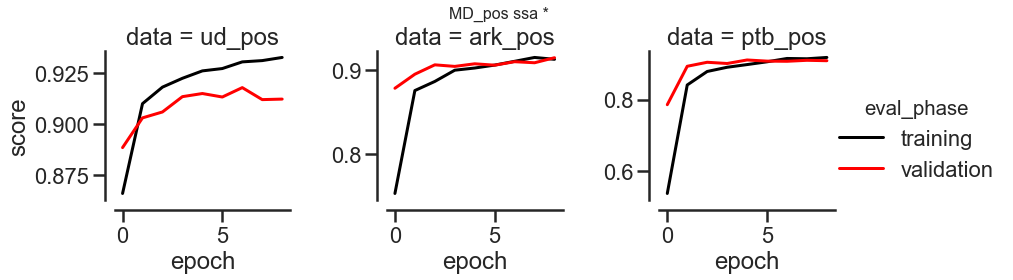

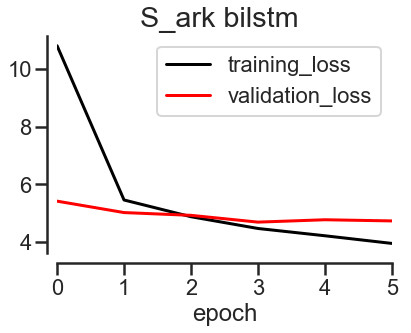

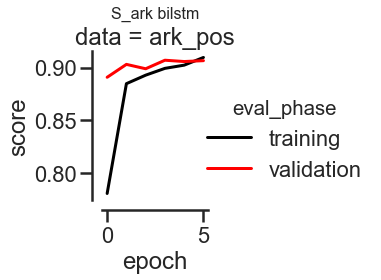

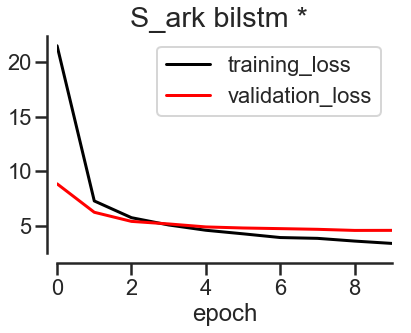

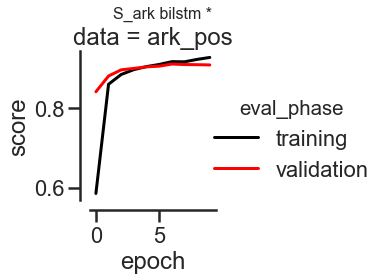

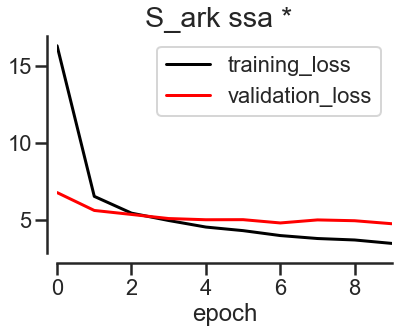

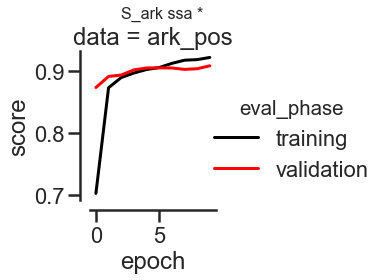

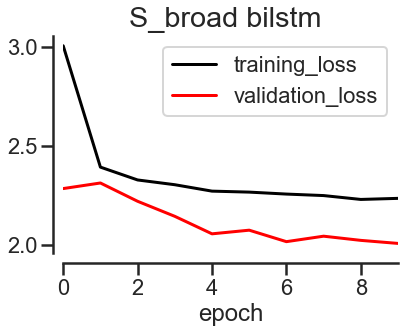

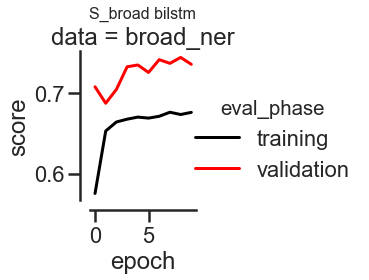

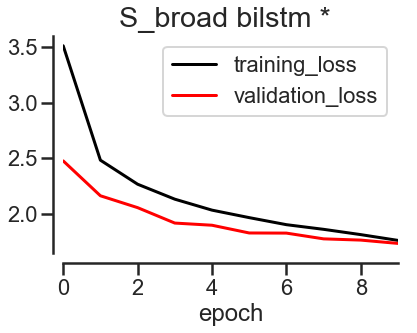

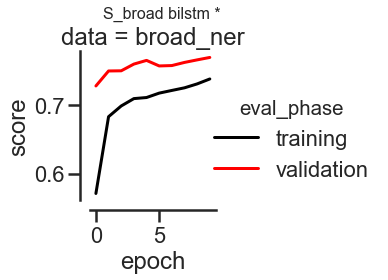

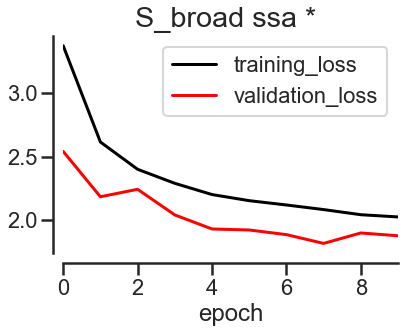

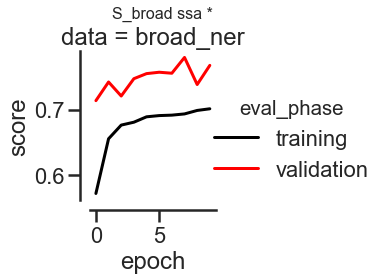

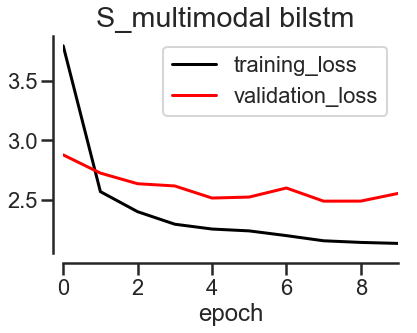

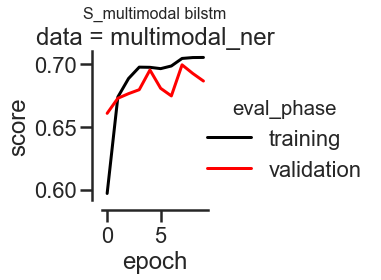

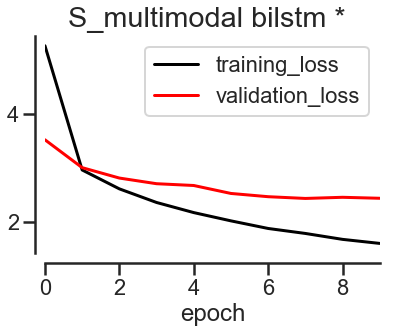

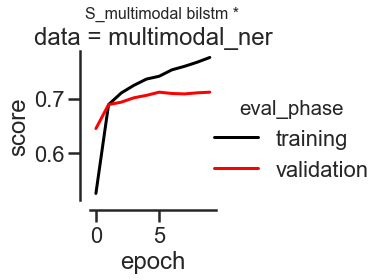

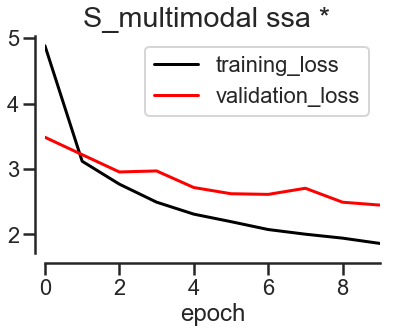

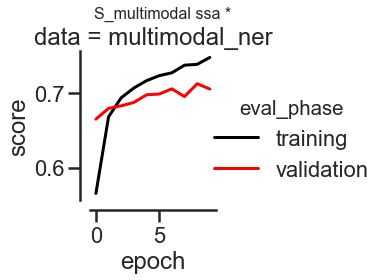

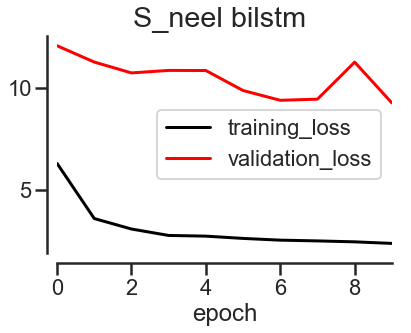

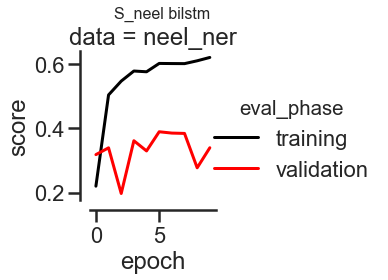

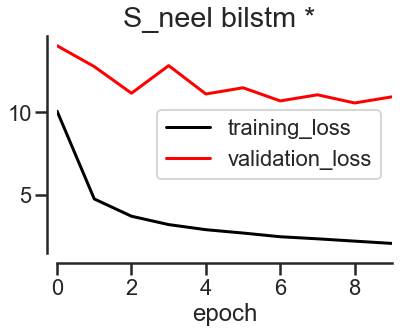

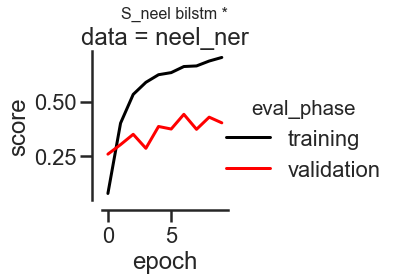

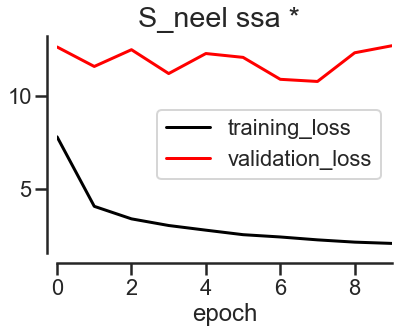

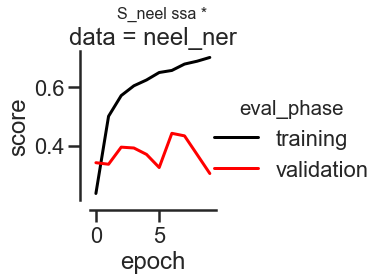

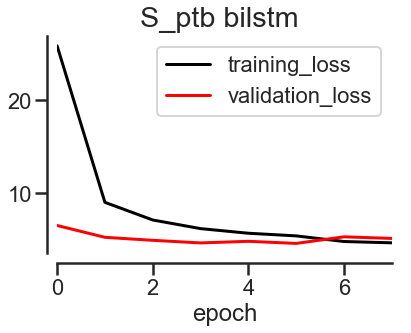

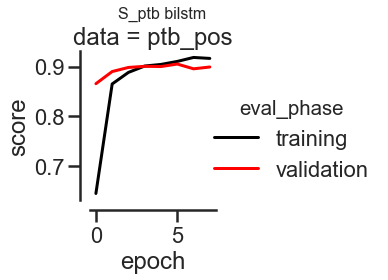

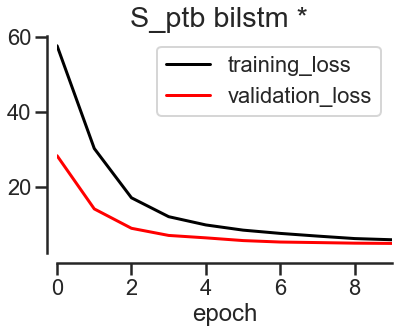

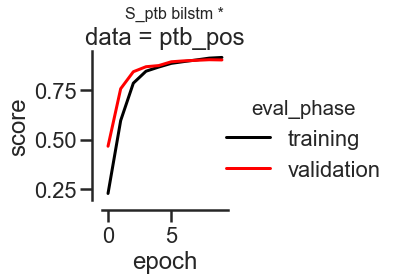

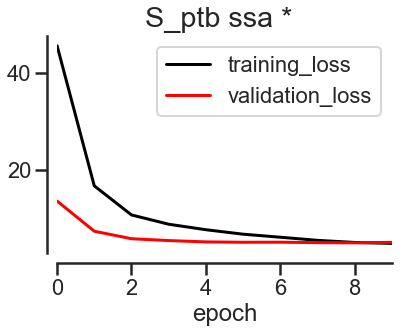

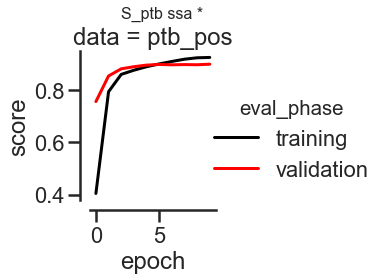

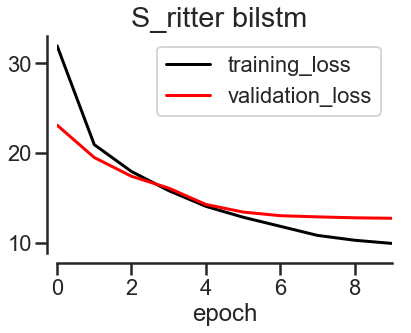

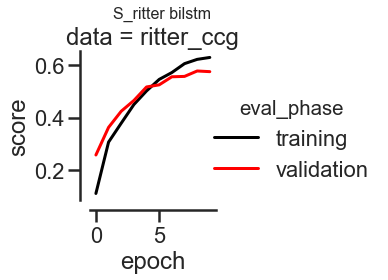

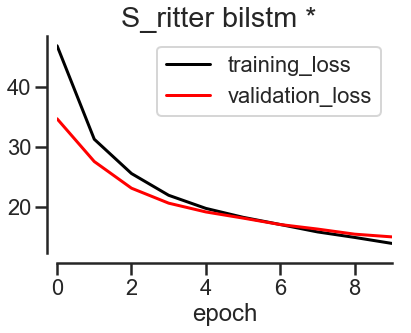

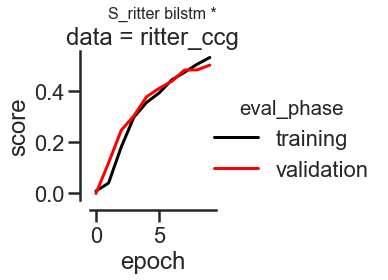

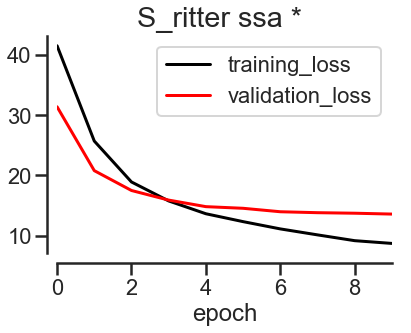

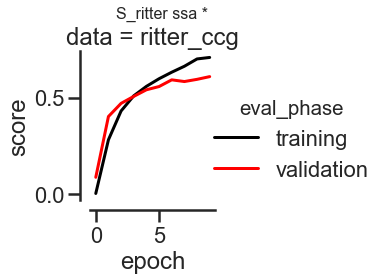

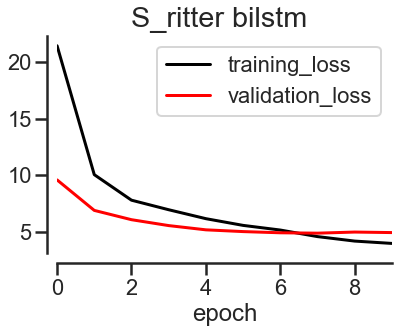

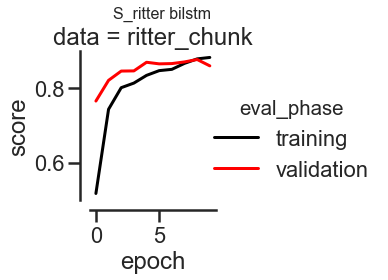

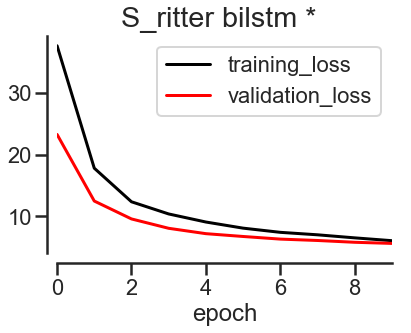

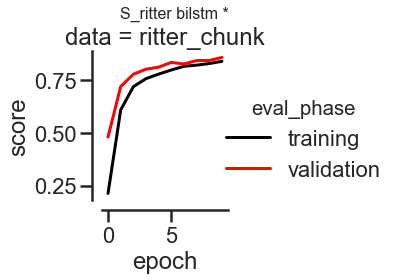

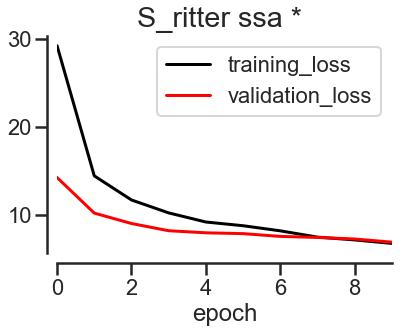

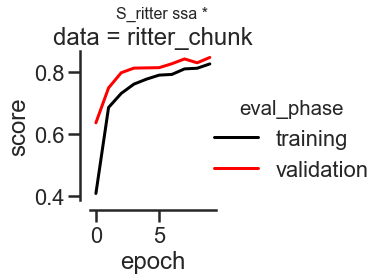

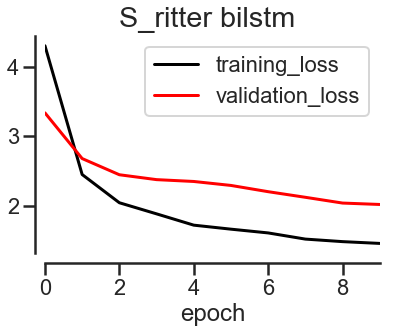

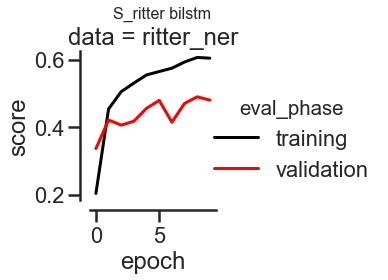

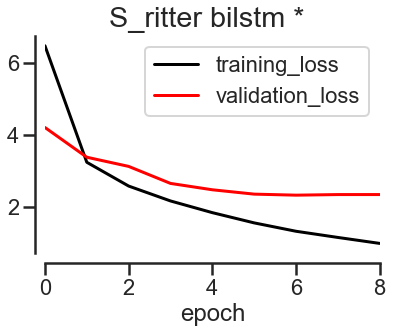

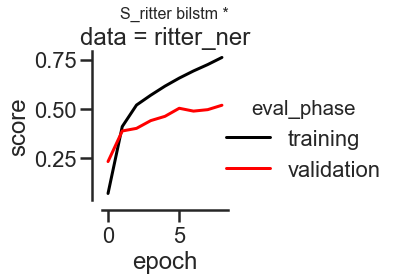

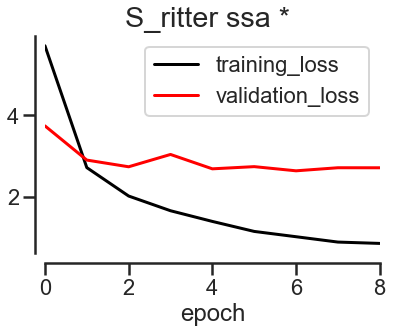

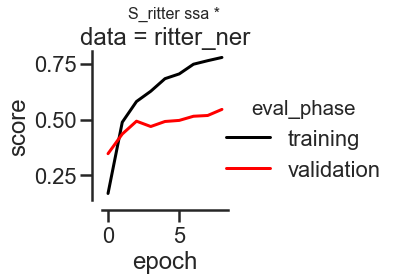

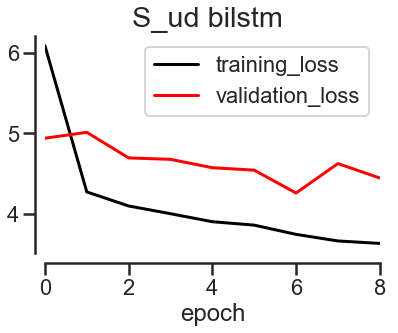

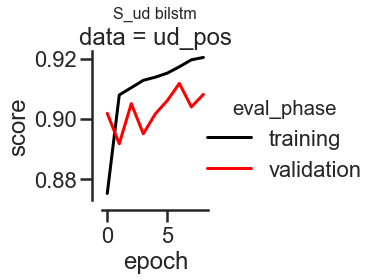

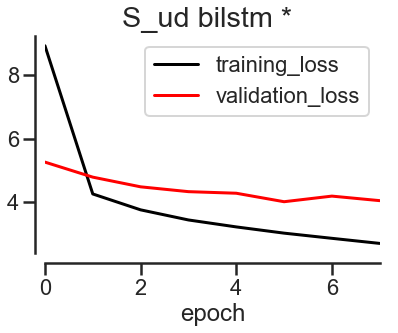

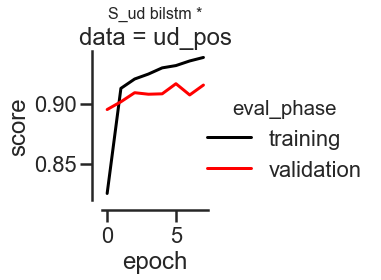

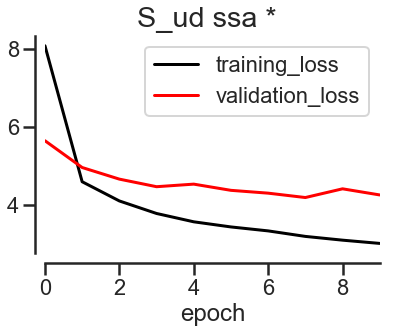

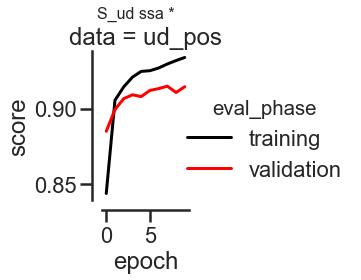

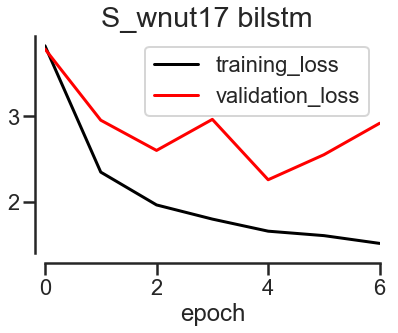

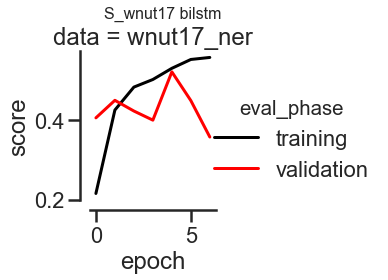

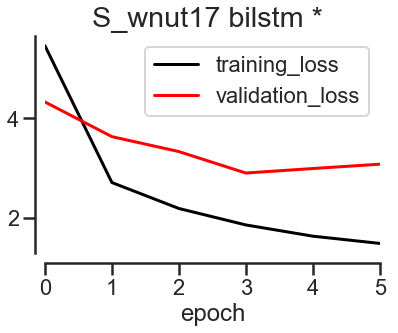

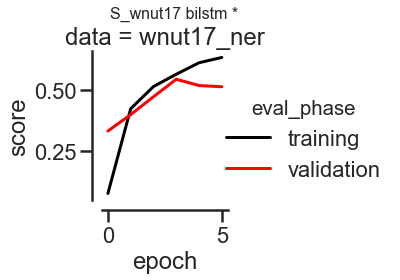

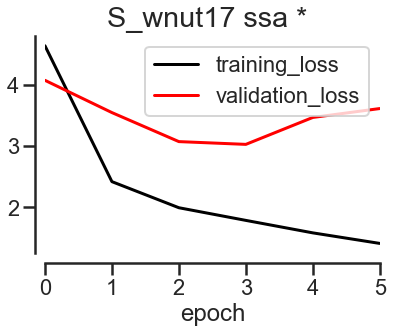

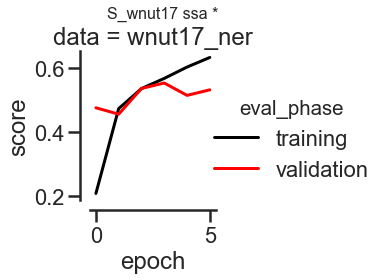

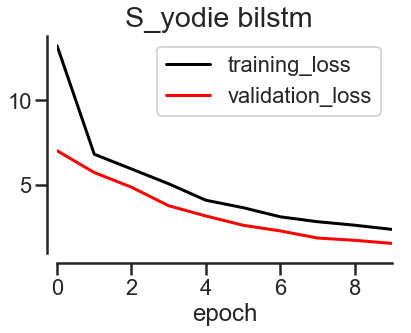

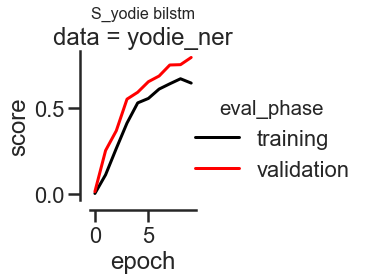

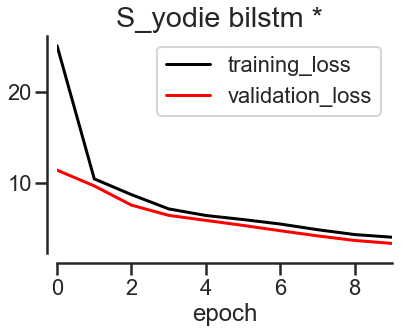

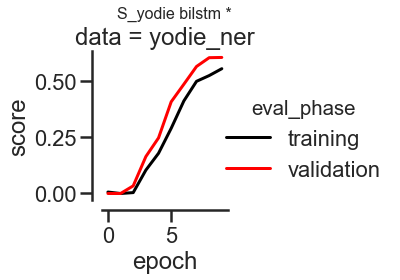

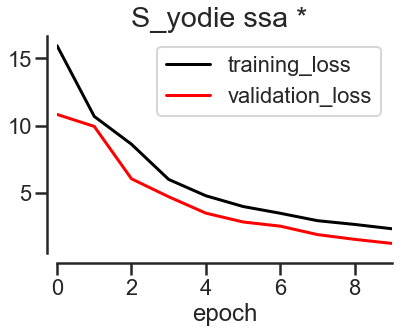

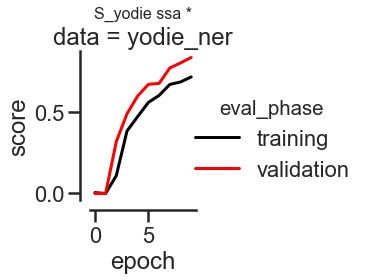

In [8]:
for model_path in model_paths:
    plot_model(model_path)